# Exercício 3
## 3ª Lista de Fundamentos em Redes Neurais e Aprendizagem Estatística
### by Lorran de Araújo Durães Soares

Imports:

In [1]:
from tensorflow.keras.datasets import cifar10
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import cv2

np.random.seed(42) # setando semente

2024-08-28 10:05:31.909168: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 10:05:32.153157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 10:05:32.235713: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 10:05:32.255191: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 10:05:32.496060: I tensorflow/core/platform/cpu_feature_guar

### Pré Processamento

Carregando conjunto de dados:

In [2]:
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

# concatena os dados
x_all = np.concatenate((data_train, data_test), axis=0)
y_all = np.concatenate((label_train, label_test), axis=0)

Filtrando para apenas carros e aviões:

In [3]:
categories = [0, 1]  # airplane, car
train_filter = np.isin(y_all, categories)

x_filt, y_filt = x_all[train_filter.flatten()], y_all[train_filter.flatten()]

Reduzindo conjunto de dados:

In [26]:
sample_size = 0.1
X_sample, _, y_sample, _ = train_test_split(x_filt, y_filt, test_size=1-sample_size, random_state=42, stratify=y_filt)
print(x_filt.shape)
print(X_sample.shape)

(12000, 32, 32, 3)
(1200, 32, 32, 3)


Plotando imagens do conjunto de dados:

In [27]:
def plot_images_grid(images, titles, rows=2, cols=4):

    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.flatten()  # achata o array de eixos para facilitar o acesso

    for img, title, ax in zip(images, titles, axes):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

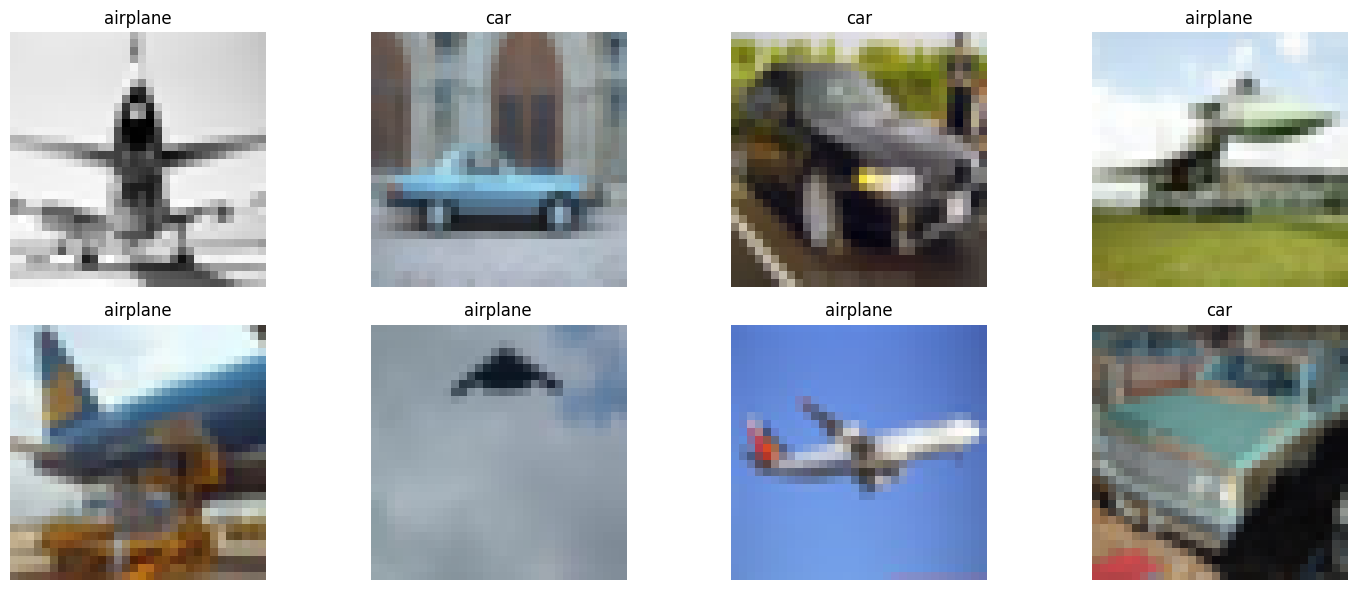

In [31]:
category_labels = {0: 'airplane', 1: 'car'}
num_imagem = 17
list_imgs = []
example_label = []

for i in range(8):
    list_imgs.append(X_sample[num_imagem*i])
    example_label.append(category_labels[y_sample[num_imagem*i][0]])

plot_images_grid(images=list_imgs, titles=example_label)

Convertendo para cinza:

In [32]:
def convert_to_gray(images):
    gray_images = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])
    return gray_images

In [33]:
x_all_gray = convert_to_gray(X_sample)

Vetorizando:

In [34]:
x_all_gray_flattened = x_all_gray.reshape(x_all_gray.shape[0], -1)

Conferindo formato:

In [35]:
print(f'Formato original das imagens: {x_filt.shape[1:]}')
print(f'Formato das imagens após conversão para cinza: {x_all_gray.shape[1:]}')
print(f'Formato das imagens vetorizadas: {x_all_gray_flattened.shape[1]}')

Formato original das imagens: (32, 32, 3)
Formato das imagens após conversão para cinza: (32, 32)
Formato das imagens vetorizadas: 1024


Escalando os dados:

In [36]:
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(x_all_gray_flattened)

Dividindo dados e embaralhando:

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_sample_scaled, y_sample, test_size=0.3, random_state=42, shuffle=True, stratify=y_sample)

Olhando a distribuição do conjunto de testes:

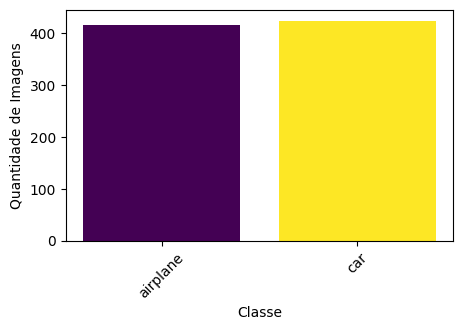

In [38]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
class_counts_train = dict(zip(unique_train, counts_train))

unique_test, counts_test = np.unique(y_test, return_counts=True)
class_counts_test = dict(zip(unique_test, counts_test))

class_names = ['airplane', 'car']

# Largura das barras
bar_width = 0.35

indices = np.arange(len(class_counts_train))

colors_train = plt.cm.viridis(0.6)  # Cor para o conjunto de treinamento
colors_test = plt.cm.plasma(0.6)  # Cor para o conjunto de teste

# Plotar o histograma do conjunto de treinamento
plt.figure(figsize=(6, 4))
plt.bar(indices, class_counts_train.values(), width=bar_width, label='Treinamento', color=colors_train)

# Plotar o histograma do conjunto de teste
plt.bar(indices + bar_width, class_counts_test.values(), width=bar_width, label='Teste', color=colors_test)

# Configurar o gráfico
plt.xlabel('Classe')
plt.ylabel('Quantidade de Imagens')
plt.xticks(indices + bar_width / 2, class_names, rotation=0)
plt.legend()

plt.show()

# Letra a):

Aplicando PCA no conjunto de treino:

In [39]:
pca = PCA()
pca.fit(X_train)

PCA()

Calculando e plotando variância explicada:

In [40]:
# Variância explicada cumulativa
variancia_explicada_cumulativa = np.cumsum(pca.explained_variance_ratio_)

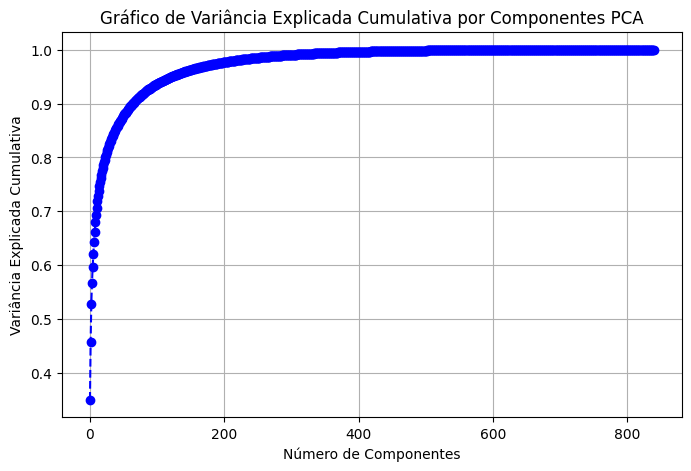

In [41]:
# Plotar o gráfico
plt.figure(figsize=(8, 5))
plt.plot(variancia_explicada_cumulativa, marker='o', linestyle='--', color='b')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Gráfico de Variância Explicada Cumulativa por Componentes PCA')
plt.grid()
plt.show()

Encontrando número de componentes que explicam pelo menos 95% da variância:

In [42]:
# Calcular a variância explicada cumulativa
variancia_explicada_cumulativa = np.cumsum(pca.explained_variance_ratio_)

# Encontrar o número de componentes que explicam pelo menos 95% da variância
n_componentes_95 = np.argmax(variancia_explicada_cumulativa >= 0.95) + 1

print(f'Número de componentes que explicam pelo menos 95% da variância: {n_componentes_95}')

Número de componentes que explicam pelo menos 95% da variância: 123


Reduzindo PCA para este número de componentes:

In [43]:
pca = PCA(n_components=n_componentes_95)
x_train_pca = pca.fit_transform(X_train)

Coloca o conjunto de treino na dimensão do pca:

In [44]:
X_test_pca = pca.transform(X_test)

Plotando PCA obtido:

In [45]:
def plot_kpca(x, y, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x[:, 3], x[:, 4], c=y.ravel(), cmap='viridis', s=10)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

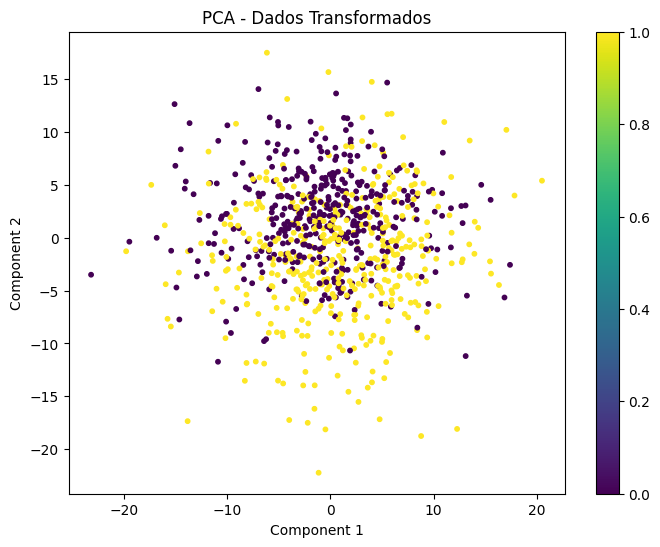

In [46]:
plot_kpca(x_train_pca, y_train, 'PCA - Dados Transformados')

Treina o LDA:

In [49]:
kf1 = KFold(n_splits=4, shuffle=True, random_state=42)

# lista para armazenar os modelos
lda = []

# itera sobre cada fold
for fold, (train_index, test_index) in enumerate(kf1.split(x_train_pca)):
    
    X_train2, X_val = x_train_pca[train_index], x_train_pca[test_index]
    y_train2, y_val = y_train[train_index], y_train[test_index]
    
    lda = LinearDiscriminantAnalysis(n_components=1)
    X_lda = lda.fit(X_train2, y_train2.ravel()).transform(X_train2)

    # Avaliando o modelo
    y_pred1 = lda.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred1)
    print(f"Acurácia do LDA no conjunto de validação para o fold {fold+1}: {accuracy:.2f}")

    y_pred2 = lda.predict(X_test_pca)
    accuracy2 = accuracy_score(y_test, y_pred2)
    print(f"Acurácia do LDA no conjunto de testes para o fold {fold+1}: {accuracy2:.2f}")

    print("====================================================================================")

Acurácia do LDA no conjunto de validação para o fold 1: 0.74
Acurácia do LDA no conjunto de testes para o fold 1: 0.75
Acurácia do LDA no conjunto de validação para o fold 2: 0.74
Acurácia do LDA no conjunto de testes para o fold 2: 0.71
Acurácia do LDA no conjunto de validação para o fold 3: 0.64
Acurácia do LDA no conjunto de testes para o fold 3: 0.76
Acurácia do LDA no conjunto de validação para o fold 4: 0.75
Acurácia do LDA no conjunto de testes para o fold 4: 0.75


# Letra b):